<a href="https://colab.research.google.com/github/abou96/WorldBankProject/blob/dev/World_Bank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wbgapi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Libraries & Dependencies
## wbgapi has a pandas support

In [ ]:
import wbgapi as wb
import wbdata as wb2
import pandas as pd
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import matplotlib
from datetime import datetime
from dataclasses import dataclass


In [ ]:
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

Query the environmental score, methane emission (kt of CO2 equivalent)

In [ ]:
wb.series.info(q='methane')

id,value
EN.ATM.METH.AG.KT.CE,Agricultural methane emissions (thousand metric tons of CO2 equivalent)
EN.ATM.METH.AG.ZS,Agricultural methane emissions (% of total)
EN.ATM.METH.EG.KT.CE,Methane emissions in energy sector (thousand metric tons of CO2 equivalent)
EN.ATM.METH.EG.ZS,Energy related methane emissions (% of total)
EN.ATM.METH.KT.CE,Methane emissions (kt of CO2 equivalent)
EN.ATM.METH.ZG,Methane emissions (% change from 1990)
,6 elements


Info about the metrics :
At standard temperature and pressure, one metric ton of carbon dioxide (CO₂) would fill a sphere 32 feet (about 9.8 meters) in diameter. The average car in the U.S. will produce this over a three-month period.

In [ ]:
QUERY_ID = ['EN.ATM.METH.EG.KT.CE']

predictors_id = ['EN.ATM.METH.EG.ZS', 'EN.ATM.METH.EG.ZS',
                 'EN.ATM.METH.ZG', 'EN.ATM.METH.AG.ZS', 'EN.ATM.METH.AG.KT.CE' ]

predictors_id2 = ['EN.ATM.CO2E.KT', 'EG.USE.PCAP.KG.OE',
                 'NV.IND.TOTL.ZS' ]

CURRENT_YEAR_AVAILABLE = 2021

**GET OUR DATA FROM WORLD BANK API**

This 2 functions help us retrieve the data from the API using CountryAlpha2Code and the period time
- CountryAlpha2Code : later.....
- period time : later....

In [ ]:
def HandlingPeriodFormatInput(period_time) :
  
  if not isinstance(period_time, list):
    raise Exception ("period time should be in a format list like this : [2021]")

  LastYearToPredict = max(period_time)
  
  if len(period_time) > 3 :
    raise Exception ("The format given is not correct try this format [initial date, final date, step")
  if len(period_time) == 2 :
    period_time.insert(2, 1)
    warnings.warn("the format should be [initial date, final date, step")
  
  if max(period_time) > CURRENT_YEAR_AVAILABLE + 1 or min(period_time) > CURRENT_YEAR_AVAILABLE:
    # period_time[0] , period_time[1]= min(2021, period_time[0]), min(2022, period_time[1])
    new_period_time = range(min(2021, period_time[0]), min(2022, period_time[1]), period_time[2])
  else :
     new_period_time = range(period_time[0], period_time[1], period_time[2])

  return new_period_time, period_time[0], LastYearToPredict




In [ ]:
HandlingPeriodFormatInput([2010, 2026, 1])

(range(2010, 2022), 2010, 2026)

In [ ]:
@dataclass
class Country :
  name : str
  CountryAlpha2Code : str
  period_time : list
  query_id : list

  def getDataMethEmissionByCountryAndYears(self) -> pd.DataFrame :
    period_time_range,  _, _ = HandlingPeriodFormatInput(self.period_time)
    df = wb.data.DataFrame(self.query_id, self.CountryAlpha2Code, time = period_time_range, columns='series')   
    return df.reset_index()

In [ ]:
France = Country('France', 'FRA', [2010, 2026, 1], QUERY_ID)
France.period_time

# senegal.period_time

[2010, 2026, 1]

In [ ]:
df_France = France.getDataMethEmissionByCountryAndYears()
France.period_time
df_France

,time,EN.ATM.METH.EG.KT.CE
0,YR2010,5770.0
1,YR2011,4870.0
2,YR2012,5230.0
3,YR2013,5500.0
4,YR2014,4680.0
5,YR2015,4920.0
6,YR2016,5240.0
7,YR2017,5130.0
8,YR2018,4990.0
9,YR2019,5060.0


**DATA PREPROCESSING**

In [ ]:
@dataclass
class DataMethCountryPreprocessing :
  country : Country
  df: pd.DataFrame


  def CleaningAndRename(self):
    self.df['date'] = self.df['time'].str[2:]
    self.df['date'] = pd.to_datetime(self.df['date'])
    self.df = self.df.rename(columns = {'EN.ATM.METH.EG.KT.CE' : 'ktofCO2'})
    del self.df['time']
    self.df = self.df.set_index('date')

  def MissingValue(self) :
     print('count null value :', self.df.isnull().sum())

  def HandlingFormatDateIndex(self) :
    _, BeginYear, LastYearToPredict = HandlingPeriodFormatInput(self.country.period_time)
    start = str(BeginYear) + "-01-01"
    end = str(LastYearToPredict) + "-01-01"
    dates = pd.date_range(start=start,end=end)
    self.df= self.df.reindex(dates, fill_value=0)
    self.df = self.df.resample('Y').sum()

In [ ]:
DMCP = DataMethCountryPreprocessing(France, df_France)
DMCP.CleaningAndRename()
DMCP.MissingValue()
DMCP.HandlingFormatDateIndex()

count null value : ktofCO2    2
dtype: int64


In [ ]:
df = DMCP.df

Cleaning Data

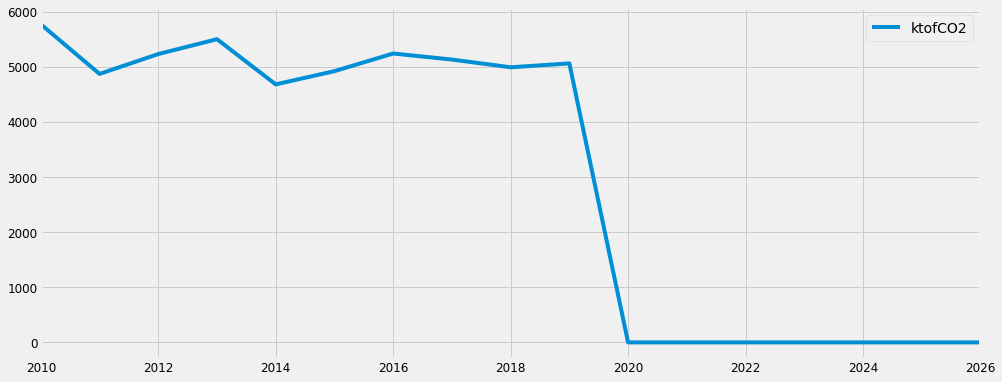

In [ ]:
df.plot(figsize=(15, 6))
plt.show()

In [ ]:
#Handling Missing data

In [ ]:
#Interpolation method
# Extrapolation
#MeanMedianMode
#Forward/backward fill
#Time-based interpolation

In [1]:
import pandas as pd

# create a sample time series dataframe with missing values
data = {'date': ['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04', '2022-01-05'],
        'value': [1, None, 3, None, 5]}
df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# use linear interpolation to fill missing values
df.interpolate(method='linear', inplace=True)

In [ ]:
df

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Handle missing value

In [ ]:
# Define the indicators to retrieve data for
indicators = QUERY_ID + predictors_id2
# Retrieve the data for all countries and all years
France = Country('France', 'FRA', [1960, 2026, 1], indicators)
df_France = France.getDataMethEmissionByCountryAndYears()
DMCP = DataMethCountryPreprocessing(France, df_France)
DMCP.CleaningAndRename()
DMCP.MissingValue()
DMCP.HandlingFormatDateIndex()
df_France = DMCP.df

# Replace missing values with NaN
df_France.replace(0, pd.np.nan, inplace=True)
print('whyyyyy', df_France[df_France['ktofCO2'].isna()])
print(df_France)

print('FRANNNNNCE', df_France)
# Split the data into a training set and a test set

train_data = df_France.dropna(subset=['ktofCO2'])
test_data = df_France[df_France['ktofCO2'].isna()]

# print('traindata', train_data)
print('testdata', test_data)
# Define the predictors and the response variable
X_train = train_data.drop(columns='ktofCO2')
print('trainnnnnnn', X_train)

y_train = train_data['ktofCO2']
X_test = test_data.drop(columns= 'ktofCO2')
print('testtttttttttt', y_train)
print(len(X_train))
print(len(y_train))
# Fit the linear regression model
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)

print(X_test)
# Predict the missing values
y_pred = linear_regression.predict(X_test)

# Add the predicted values to the test set
test_data[QUERY_ID] = y_pred

# Concatenate the test set with the training set
df = pd.concat([train_data, test_data])

print(df)

# Calculate the root mean squared error
rmse = mean_squared_error(df['ktofCO2'], y_pred, squared=False)
print("Root Mean Squared Error: ", rmse)


count null value : EG.USE.PCAP.KG.OE     6
EN.ATM.CO2E.KT       32
ktofCO2              32
NV.IND.TOTL.ZS        0
dtype: int64
whyyyyy             EG.USE.PCAP.KG.OE  EN.ATM.CO2E.KT  ktofCO2  NV.IND.TOTL.ZS
1960-12-31        1698.222250             NaN      NaN       30.275014
1961-12-31        1748.120660             NaN      NaN       30.666667
1962-12-31        1869.827683             NaN      NaN       29.986293
1963-12-31        1999.628470             NaN      NaN       29.668934
1964-12-31        2106.408428             NaN      NaN       30.167479
1965-12-31        2132.768529             NaN      NaN       30.281856
1966-12-31        2144.787082             NaN      NaN       30.056987
1967-12-31        2267.809310             NaN      NaN       29.712435
1968-12-31        2376.530580             NaN      NaN       29.332637
1969-12-31        2550.970426             NaN      NaN       28.793407
1970-12-31        2964.808079             NaN      NaN       29.045013
1971-12-31  

ValueError: ignored

In [ ]:
from wbgapi import WorldBank

# Create a WorldBank object
wb = WorldBank()

# Define the country code and year
country_code = 'USA'
year = '2018'

# Get the methane emissions data for the specified country and year
methane_emissions = wb.indicator(indicator='EN.ATM.METH.KT.CE', country=country_code, date=year)

# Get the data for other indicators
co2_emissions = wb.indicator(indicator='EN.ATM.CO2E.KT', country=country_code, date=year)
energy_use = wb.indicator(indicator='EG.USE.PCAP.KG.OE', country=country_code, date=year)
industrial_production = wb.indicator(indicator='NV.IND.TOTL.ZS', country=country_code, date=year)
